In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

from shapely.geometry import Polygon

## Import and clean data

In [2]:
train_fp = os.path.join(os.getcwd(),'aux_data','trainset.csv')
features_df = pd.read_csv(train_fp)
features_df.head(4)

,Unnamed: 0,geometry,x,y,r,g,b,nifr,iceplant
0,0,POINT (238534.77144037225 3810764.4391108337),238534.771440,3.810764e+06,89,84,89,144,1
1,1,POINT (238516.67475820333 3810768.371394962),238516.674758,3.810768e+06,100,88,93,148,1
2,2,POINT (238496.0413784355 3810771.828721741),238496.041378,3.810772e+06,97,93,96,140,1
3,3,POINT (238497.93042821612 3810771.2369597284),238497.930428,3.810771e+06,87,80,86,137,1


In [3]:
features_df.drop(['geometry','Unnamed: 0','x','y'],axis=1,inplace=True)

In [4]:
# Descriptive statistics for each column 
features_df.describe()

,r,g,b,nifr,iceplant
count,224.000000,224.000000,224.000000,224.000000,224.000000
mean,84.093750,91.187500,88.955357,146.495536,0.330357
std,32.576714,28.561485,21.804014,36.055015,0.471395
min,29.000000,42.000000,59.000000,40.000000,0.000000
25%,64.000000,76.000000,75.000000,126.000000,0.000000
50%,81.000000,81.500000,83.500000,148.000000,0.000000
75%,91.250000,100.000000,96.000000,170.000000,1.000000
max,196.000000,192.000000,180.000000,213.000000,1.000000


In [5]:
features_df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')

,iceplant,count
0,0,150
1,1,74


## Crete test and training sets

In [6]:
# Labels are the values we want to predict
labels = np.array(features_df['iceplant'])

# Remove the labels from the features and save them separately
features= features_df.drop('iceplant', axis = 1)
features_names = list(features.columns)

#Convert to numpy array
features = np.array(features)

In [7]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                                            labels, 
                                                                            test_size = 0.3, 
                                                                            random_state = 42)

In [8]:
print('Training Features Shape:', train_features.shape) 
print('Training Labels Shape:', train_labels.shape) 
print('Testing Features Shape:', test_features.shape) 
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (156, 4)
Training Labels Shape: (156,)
Testing Features Shape: (68, 4)
Testing Labels Shape: (68,)


In [9]:
# --- check proportions of ice plant vs no ice plant in train/test sets
print('TRAIN SET: Iceplant / no iceplant counts')
unique, counts = np.unique(train_labels,return_counts=True)
print(np.column_stack((unique,counts)), '\n')

print('TEST SET: Iceplant / no iceplant counts')
unique, counts = np.unique(test_labels,return_counts=True)
print(np.column_stack((unique,counts)))

TRAIN SET: Iceplant / no iceplant counts
[[  0 104]
 [  1  52]] 

TEST SET: Iceplant / no iceplant counts
[[ 0 46]
 [ 1 22]]


## Fit a random forest classifier (RFC)

In [10]:
rfc = RandomForestClassifier(n_estimators = 100, 
                           random_state = 42)
rfc.fit(train_features,train_labels)

RandomForestClassifier(random_state=42)

In [11]:
predictions_class = rfc.predict(test_features)

In [12]:
# Calculate the absolute errors
errors_class = abs(predictions_class - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_class), 2))

Mean Absolute Error: 0.07


## RFC: ROC curve

In [13]:
from sklearn.metrics import RocCurveDisplay

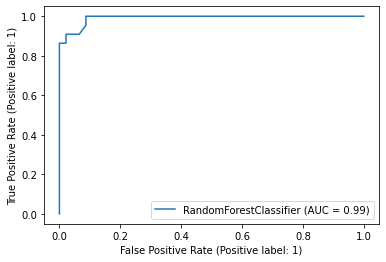

In [14]:
ax = plt.gca()
rf_disp = RocCurveDisplay.from_estimator(rfc, test_features, test_labels, ax=ax)

## RFC: Confusion matrix

In [15]:
N = test_labels.shape[0]
results = confusion_matrix(test_labels,predictions_class, normalize = 'true')

# print('true negatives %', np.round(results[0,0]/N*100,2), 
#       '    false positives %', np.round(results[0,1]/N*100,2))
# print('false negatives %', np.round(results[1,0]/N*100,2), '    true positives %', np.round(results[1,1]/N*100,2))

In [16]:
confmtx = confusion_matrix(test_labels,predictions_class)
print('true negatives:', confmtx[0,0], 
      '    false positives:', confmtx[0,1])
print('false negatives:', confmtx[1,0], 
      '    true positives:', confmtx[1,1])
print()
unique, counts = np.unique(test_labels,return_counts=True)

print('true negative:', np.round(confmtx[0,0]/counts[0]*100,2))
print('true positive rate:', np.round(confmtx[1,1]/counts[1]*100,2))

true negatives: 43     false positives: 3
false negatives: 2     true positives: 20

true negative: 93.48
true positive rate: 90.91


## Random Forest Regression (RFR)

In [17]:
# Instantiate model with 1000 decision trees
rfr = RandomForestRegressor(n_estimators = 100, 
                           random_state = 42)
# Train the model on training data 
rfr.fit(train_features, train_labels) 

RandomForestRegressor(random_state=42)

In [18]:
# Use the forest's predict method on the test data 
predictions = rfr.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.09


## RFR: Classifcation based on threshold 

In [19]:
thresh = 0.4

test = pd.DataFrame(test_features, columns=features_names)
test['iceplant']=test_labels
test['predictions']= predictions
test['classified_as'] = test.predictions.apply(lambda x : 1 if x>thresh else 0)

## RFR: Confusion matrix

In [20]:
confmtx = confusion_matrix(test['iceplant'],test['classified_as'])
print('true negatives:', confmtx[0,0], 
      '    false positives:', confmtx[0,1])
print('false negatives:', confmtx[1,0], 
      '    true positives:', confmtx[1,1])
print('\n')
unique, counts = np.unique(test_labels,return_counts=True)

print('true negative:', np.round(confmtx[0,0]/counts[0]*100,2))
print('true positive rate:', np.round(confmtx[1,1]/counts[1]*100,2))

true negatives: 42     false positives: 4
false negatives: 2     true positives: 20


true negative: 91.3
true positive rate: 90.91


## Applyign RFC model to campus point image

### Loading subset of NAIP scene

In [21]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
item.assets  # click on rendered preview to look at image

{'image': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411934_sw_11_060_20180722_20190209.tif>,
 'metadata': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_fgdc_2018/34119/m_3411934_sw_11_060_20180722.txt>,
 'thumbnail': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411934_sw_11_060_20180722_20190209.200.jpg>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=naip&item=ca_m_3411934_sw_11_060_20180722_20190209&assets=image&asset_bidx=image%7C1%2C2%2C3>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=naip&item=ca_m_3411934_sw_11_060_20180722_20190209&assets=image&asset_bidx=image%7C1%2C2%2C3>}

In [22]:
# use one of these polygons to make a window and load only the portion of the raster we need

#  Campus Point + Campus + Goleta Beach
# reduce_box = Polygon([
#     [-119.8533036004,34.4025961754],
#     [-119.8322357862,34.4025961754],
#     [-119.8322357862,34.4198342586],
#     [-119.8533036004,34.4198342586],
#     [-119.8533036004,34.4025961754]])

# Campus Point only
reduce_box = Polygon([
    [-119.8534713523,34.4028697719],
    [-119.8409772016,34.4028697719],
    [-119.8409772016,34.4129840686],
    [-119.8534713523,34.4129840686],
    [-119.8534713523,34.4028697719]])


reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

win = ds.window(*reduce.total_bounds)

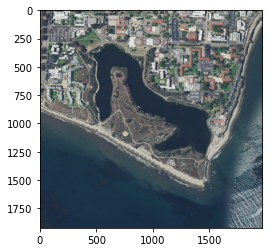

In [23]:
# Visualization of RGB bands to double check this is our AOI
plt.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))

In [24]:
subset = rasterio.open(href).read([1,2,3,4], window=win)
subset.shape

(4, 1923, 1967)

### Preparing data to input into RFC predict

In [25]:
# reshape image into a np.array where each row is a pixel and the columns are the bands
pixels = subset.reshape([4,-1]).T
pixels

array([[111, 107, 109,  87],
       [114, 108, 110,  93],
       [109, 104, 110,  89],
       ...,
       [141, 149, 162,  96],
       [150, 164, 162, 107],
       [180, 175, 172,  95]], dtype=uint8)

### Predict iceplant location using RFC

In [26]:
predictions_class = rfc.predict(pixels)

In [27]:
# turn back into original raster dimensions
pred_to_pixels = predictions_class.reshape([subset.shape[1],-1])
print(pred_to_pixels.shape)


(1923, 1967)


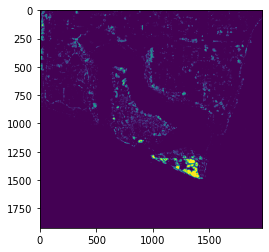

In [28]:
plt.imshow(pred_to_pixels)

## Ice plant on Cabrillo Boulevard

In [29]:

# ********* ICEPLANT ON CABRILLO BOULEVARD ******
itemid = 'ca_m_3411935_se_11_060_20180724_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
item.assets  # click on rendered preview to look at image


{'image': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411935_se_11_060_20180724_20190209.tif>,
 'metadata': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_fgdc_2018/34119/m_3411935_se_11_060_20180724.txt>,
 'thumbnail': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411935_se_11_060_20180724_20190209.200.jpg>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=naip&item=ca_m_3411935_se_11_060_20180724_20190209&assets=image&asset_bidx=image%7C1%2C2%2C3>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=naip&item=ca_m_3411935_se_11_060_20180724_20190209&assets=image&asset_bidx=image%7C1%2C2%2C3>}

In [30]:
# Campus Point only
reduce_box = Polygon([
    [-119.6850455313,34.4098455891],
    [-119.6679797229,34.4098455891],
    [-119.6679797229,34.4192039194],
    [-119.6850455313,34.4192039194],
    [-119.6850455313,34.4098455891]]
    )

reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

win = ds.window(*reduce.total_bounds)
subset = rasterio.open(href).read([1,2,3,4], window=win)
subset.shape

(4, 1799, 2660)

In [31]:
# reshape image into a np.array where each row is a pixel and the columns are the bands
pixels = subset.reshape([4,-1]).T
predictions_class = rfc.predict(pixels)
# turn back into original raster dimensions

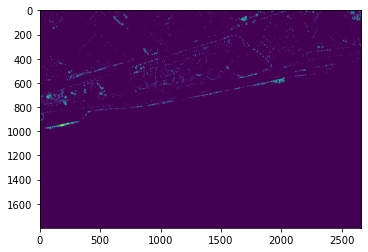

In [32]:
pred_to_pixels = predictions_class.reshape([subset.shape[1],-1])
plt.imshow(pred_to_pixels)